# Bayesian Statistics - The Challenger Disaster

This ipynotebook is an excerpt of the excellent 'Bayesian Methods for Hackers'. For the whole book, check out http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/.

Note that this Notebook requires the package *pymc*.

author: Thomas Haslwanter, date: Oct-2015

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from urllib.request import urlopen

url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_bayes/'
inFile = 'challenger_data.csv'
url = url_base + inFile
challenger_data = np.genfromtxt(urlopen(url), skip_header=1, usecols=[1, 2],
                                missing_values='NA', delimiter=',')
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


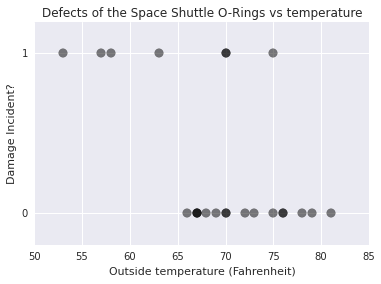

In [2]:
%matplotlib inline
sns.set_style('darkgrid')
np.set_printoptions(precision=3, suppress=True)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")

It looks clear that the probability of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature t, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it p(t), that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function*.


$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

In this model, the variable $\beta$ that describes how quickly the function changes from 1 to 0, and $\alpha$ indicates the location of this change. For example

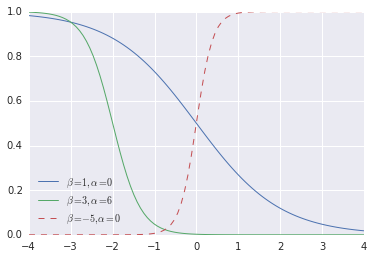

In [3]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1, \alpha = 0$", ls="-", lw=1)
plt.plot(x, logistic(x, 3, 6), label=r"$\beta = 3, \alpha = 6$", ls="-", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5, \alpha = 0$", ls="--", lw=1)

plt.legend(loc='lower left')

## Perform the MCMC-simulations

In [5]:
import pymc as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

# Define the prior distributions for alpha and beta
# 'value' sets the start parameter for the simulation
# The second parameter for the normal distributions is the "precision",
# i.e. the inverse of the standard deviation

# notice the`value` here. We explain why below.
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)


@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

# Combine the values to a model
model = pm.Model([observed, beta, alpha])

In [6]:
# Perform the simulations
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 10.1 sec

### Show the resulting posterior distributions

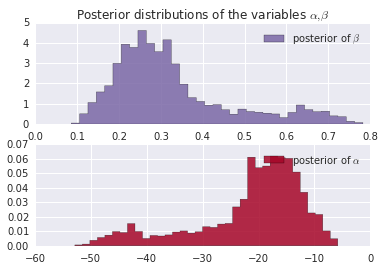

In [7]:
alpha_samples = mcmc.trace('alpha')[:, None]  # best to make them 1d
beta_samples = mcmc.trace('beta')[:, None]

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend()

### Show the probability curve

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


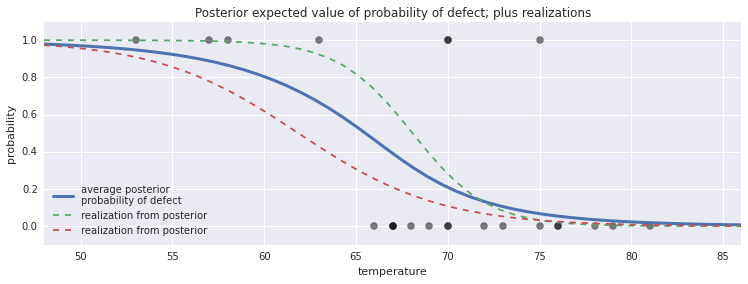

In [8]:
# Draw the probability as a function of time
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

plt.figure(figsize=(12.5, 4))

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature")

### Draw Confidence-Intervals

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


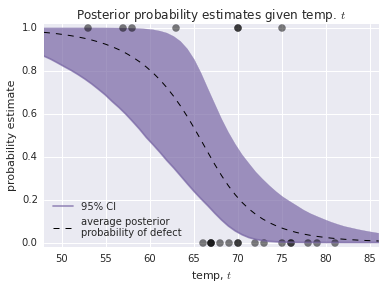

In [9]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$")